In [4]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

clear_output()

from nnsight import CONFIG

In [5]:
# Load llama3.1
llama = LanguageModel("meta-llama/Meta-Llama-3.1-8B",device="cuda")
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [125]:
output = ['a','b']
[[x] for x in output][0]

['a']

In [180]:
import torch.nn.functional as F
import numpy as np

# run the logit lens on a list of prompts
def run_prompts(model,prompts,target_tokens=None):
    output = zip(
        *[run_lens(model, prompt, target_tokens) for prompt in prompts]
    )
    return output

# run the logit lens on a single prompt, with a list of target tokens
def run_lens(model,PROMPT,target_tokens=None):
    if not target_tokens:
        lens_target_tokens, lens_token_result, lens_token_probs, lens_token_ranks, lens_token_entropy, lens_token_kldiv =logitlens(model,PROMPT)
    
        return [lens_target_tokens], [lens_token_result], [lens_token_probs], [lens_token_ranks], [lens_token_entropy], [lens_token_kldiv]

    
    target_tokens = [torch.tensor(model.tokenizer.encode(target)[1:]) for target in target_tokens]
    lens_target_tokens = []
    lens_token_result = []
    lens_token_probs = []
    lens_token_ranks = []
    lens_token_entropy = []
    lens_token_kldiv = []
    for target_token in target_tokens:
        actual_output, logit_lens_results, logit_lens_all_probs,logit_lens_ranks_by_layer,logit_lens_entropy_by_layer,logit_lens_Kldiv_by_layer= logitlens(model,PROMPT,target_token)
        lens_target_tokens.append(actual_output)
        lens_token_result.append(logit_lens_results)
        lens_token_probs.append(logit_lens_all_probs)
        lens_token_ranks.append(logit_lens_ranks_by_layer)
        lens_token_entropy.append(logit_lens_entropy_by_layer)
        lens_token_kldiv.append(logit_lens_Kldiv_by_layer)

    return lens_target_tokens,lens_token_result,lens_token_probs,lens_token_ranks,lens_token_entropy,lens_token_kldiv

    
# run the logit lens on a single prompt with one target token
def logitlens(model,PROMPT,target_token=None):
    result_by_layer = []
    probs_by_layer = []
    ranks_by_layer = []
    entropy_by_layer = []
    KLdiv_by_layer = []
    input_ids = model.tokenizer.encode(PROMPT)
    with model.trace(input_ids, remote=True) as runner:
        for layer_ix,layer in enumerate(model.model.layers):
            # Get the hidden state for the current layer
            hidden_state = layer.output[0][0]
            logit_lens_normed_last_token = model.model.norm(hidden_state)
            logit_lens_token_distribution = model.lm_head(logit_lens_normed_last_token)
            logit_lens_last_token_logit = logit_lens_token_distribution[-1:]

            # Calculate probabilities using softmax
            logit_lens_probs = F.softmax(logit_lens_last_token_logit, dim=1).save()
            probs_by_layer.append(logit_lens_probs)

            # Get the next token predicted by the model
            logit_lens_next_token = torch.argmax(logit_lens_probs, dim=1).save()
            result_by_layer.append(logit_lens_next_token)
        
        # Get the model's prediction if target_token is not specified
        tokens_out = llama.lm_head.output.argmax(dim=-1).save()
        if target_token is None:
            target_token = tokens_out[0][-1].save()
            
    #get the rank of the expected token from each layer's distribution
    for layer_probs in probs_by_layer:
        # Sort the probabilities in descending order and find the rank of the expected token. 1-based
        sorted_probs, sorted_indices = torch.sort(layer_probs, descending=True)
        expected_token_rank = (sorted_indices == target_token).nonzero(as_tuple=True)[1].item() + 1
        ranks_by_layer.append(expected_token_rank)

        # Calculate entropy for the current layer
        entropy = -(layer_probs * layer_probs.log()).sum(-1).item()
        entropy_by_layer.append(entropy)
        
        # Calculate KL divergence between the current layer and the final layer
        KL_div = (layer_probs * (layer_probs.log()-probs_by_layer[-1].log())).sum(-1).item()
        KLdiv_by_layer.append(KL_div)
    
    probs_by_layer = np.concatenate([probs[:, target_token].cpu().detach().to(torch.float32).numpy() for probs in probs_by_layer])
    logit_lens_target = llama.tokenizer.decode(target_token.item())
    results_by_layer = [model.tokenizer.decode(next_token.item()) for next_token in result_by_layer]
    return logit_lens_target,results_by_layer, probs_by_layer,ranks_by_layer,entropy_by_layer,KLdiv_by_layer

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

def plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_data, plot_type):
    warnings.filterwarnings("ignore", "Glyph .* missing from font", UserWarning)
    
    plt.figure(figsize=(10, 6))
    
    # Determine the y-axis behavior based on the plot_type and diff_factor
    for i in range(len(logit_lens_data)):
        item_data = logit_lens_data[i]
        
        if plot_type in ['entropy', 'kldiv']:  # Apply diff_factor if specified
            item_data = np.maximum(item_data, 1e-1)  # e.g., apply log scaling or offset
            
        plt.plot(range(len(item_data)), item_data, marker='x')

        if logit_lens_results:
            item_results = logit_lens_results[i]
            for layer_number, next_token in enumerate(item_results):
                plt.text(layer_number, item_data[layer_number], next_token, ha='right', va='bottom')
    
    # Set y-axis scale for entropy and kldiv
    if plot_type in ['entropy', 'kldiv']:
        plt.yscale('log')
    
    # Add legend if targets are provided
    if logit_lens_targets and plot_type not in ['entropy', 'kldiv']:
        plt.legend(logit_lens_targets)
    
    # Set common labels and title
    plt.xlabel('Layer Number')
    if plot_type == 'probs':
        plt.ylabel('Probability of Target Token')
        plt.title(f'Logit Lens for "{PROMPT}"')
    elif plot_type == 'ranks':
        plt.ylabel('Rank of Target Token')
        plt.title(f'Tuned Lens vs Logit Lens for "{PROMPT}"')
    elif plot_type == 'entropy':
        plt.ylabel('Entropy of Target Token')
        plt.title(f'Tuned Lens vs Logit Lens for "{PROMPT}"')
    elif plot_type == 'kldiv':
        plt.ylabel('KL Divergence of Target Token')
        plt.title(f'Tuned Lens vs Logit Lens for "{PROMPT}"')
    
    plt.grid(True)
    plt.show()



Running logit lens on a single prompt

In [198]:
PROMPT = "The Eiffel Tower is in the city of"
logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv= run_lens(llama,PROMPT,[' Paris',' Rome'])
# logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv= run_lens(llama,PROMPT,[])
# logit_lens_targets,logit_lens_results, logit_lens_probs,logit_lens_ranks,logit_lens_entropy,logit_lens_kldiv = run_lens(llama,PROMPT,[PROMPT.split()[-1]])

2024-11-30 23:49:52,156 8f61b3cb-0736-45d5-8063-59e211bc0e56 - RECEIVED: Your job has been received and is waiting approval.
2024-11-30 23:49:52,189 8f61b3cb-0736-45d5-8063-59e211bc0e56 - APPROVED: Your job was approved and is waiting to be run.
2024-11-30 23:49:52,247 8f61b3cb-0736-45d5-8063-59e211bc0e56 - RUNNING: Your job has started running.
2024-11-30 23:49:52,815 8f61b3cb-0736-45d5-8063-59e211bc0e56 - COMPLETED: Your job has been completed.
2024-11-30 23:49:53,825 0bc8aa56-427e-457a-a859-a19030eb6da3 - RECEIVED: Your job has been received and is waiting approval.
2024-11-30 23:49:53,858 0bc8aa56-427e-457a-a859-a19030eb6da3 - APPROVED: Your job was approved and is waiting to be run.
2024-11-30 23:49:53,901 0bc8aa56-427e-457a-a859-a19030eb6da3 - RUNNING: Your job has started running.
2024-11-30 23:49:54,439 0bc8aa56-427e-457a-a859-a19030eb6da3 - COMPLETED: Your job has been completed.


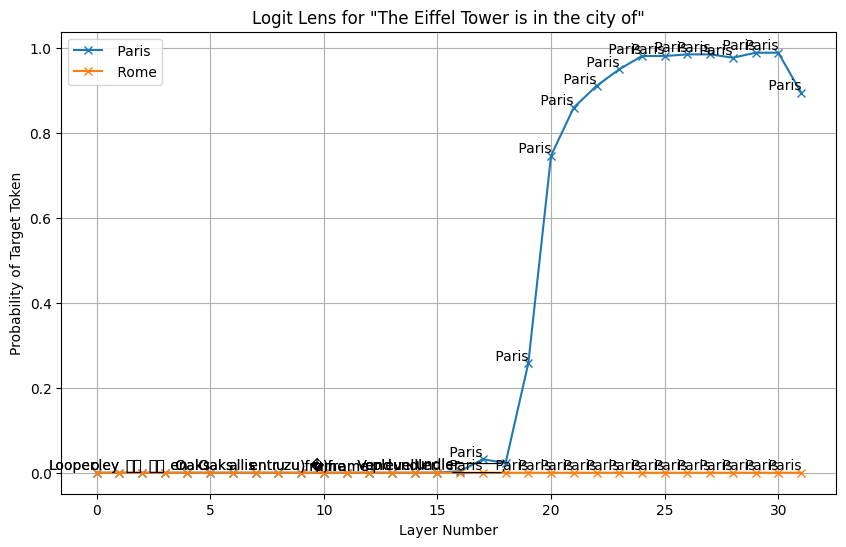

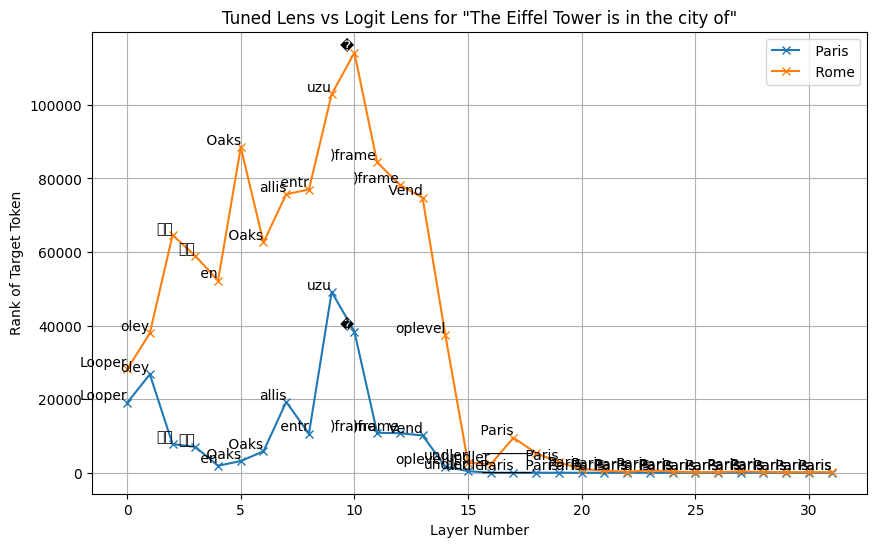

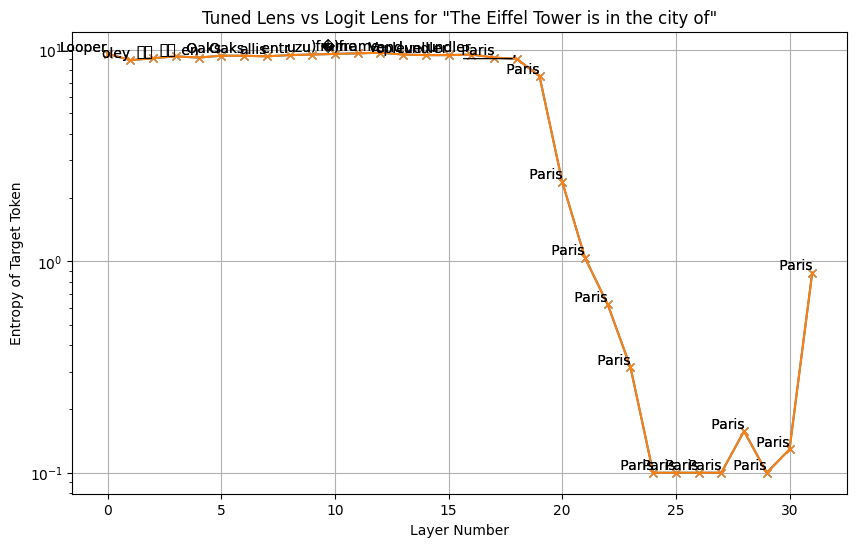

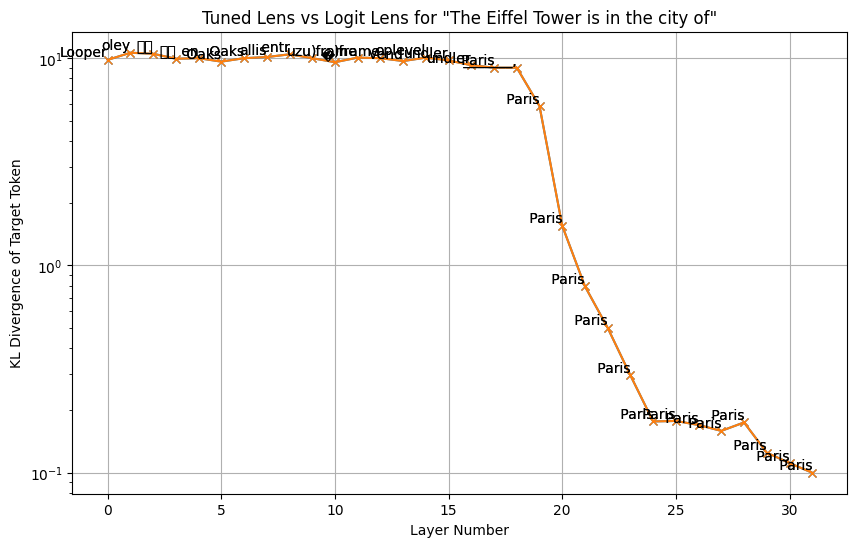

In [206]:
# Example usage
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_probs, plot_type='probs')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_ranks, plot_type='ranks')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_entropy, plot_type='entropy')
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_kldiv, plot_type='kldiv')

In [ ]:
#plot one line each
plot_lens(PROMPT,logit_lens_targets, logit_lens_results, logit_lens_probs, plot_type='probs')

#take the mean 
mean_probs  = [np.mean(np.stack(logit_lens_probs), axis=0)]
mean_ranks = [np.mean(np.stack(logit_lens_ranks), axis=0)]
plot_lens(PROMPT,None, None, mean_probs, plot_type='probs')

#take the difference
diff_probs  = [np.stack(logit_lens_probs)[0] - np.stack(logit_lens_probs)[1]]
diff_ranks = [np.stack(logit_lens_ranks)[0] - np.stack(logit_lens_ranks)[1]]
plot_lens(PROMPT,None, None, diff_probs, plot_type='probs')

Running logit lens accross a list of prompts

In [196]:
prompts= ["The Eiffel Tower is in the city of","Vatican is located in the city of"]
prompts_target_tokens, prompts_token_result, prompts_token_probs, prompts_token_ranks, prompts_token_entropy, prompts_token_kldiv = run_prompts(llama,prompts)

2024-11-30 23:49:00,062 a8f04195-0e8e-4395-9aa0-415f530d8528 - RECEIVED: Your job has been received and is waiting approval.
2024-11-30 23:49:00,088 a8f04195-0e8e-4395-9aa0-415f530d8528 - APPROVED: Your job was approved and is waiting to be run.
2024-11-30 23:49:00,168 a8f04195-0e8e-4395-9aa0-415f530d8528 - RUNNING: Your job has started running.
2024-11-30 23:49:00,749 a8f04195-0e8e-4395-9aa0-415f530d8528 - COMPLETED: Your job has been completed.
2024-11-30 23:49:01,426 822c34fc-9125-4405-9cf7-2a3d822fefe6 - RECEIVED: Your job has been received and is waiting approval.
2024-11-30 23:49:01,459 822c34fc-9125-4405-9cf7-2a3d822fefe6 - APPROVED: Your job was approved and is waiting to be run.
2024-11-30 23:49:01,504 822c34fc-9125-4405-9cf7-2a3d822fefe6 - RUNNING: Your job has started running.
2024-11-30 23:49:02,088 822c34fc-9125-4405-9cf7-2a3d822fefe6 - COMPLETED: Your job has been completed.


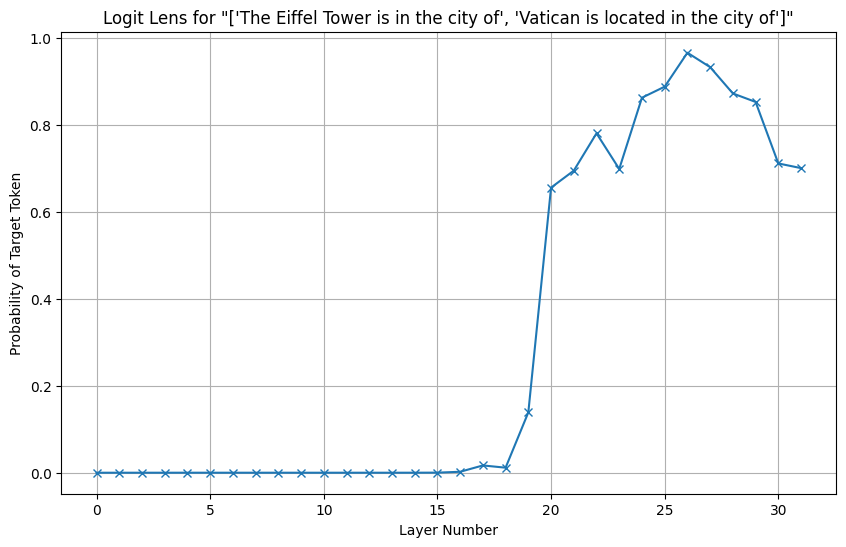

In [197]:
mean_probs  = np.mean(np.stack(prompts_token_probs), axis=0)
plot_lens(prompts,None, None, mean_probs, plot_type='probs')
